## Calling the Data Reader Class

In [1]:
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)
data = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)
print("WIDERFACE data is read!")

WIDERFACE data is read!

## Drawing a Ground Truth Image

In [30]:
include("./BBTNet/utils/ImageReader.jl")

train_reader = Image_Reader(true) # true for augmentation, false for only square resize

file_name = "22--Picnic/22_Picnic_Picnic_22_231.jpg"
img, bboxes = read_img(train_reader, wf_path * "train/images/" * file_name, data.bboxes[file_name], 640)
print("Image file is read: ", file_name, '\n')

Image file is read: 22--Picnic/22_Picnic_Picnic_22_231.jpg


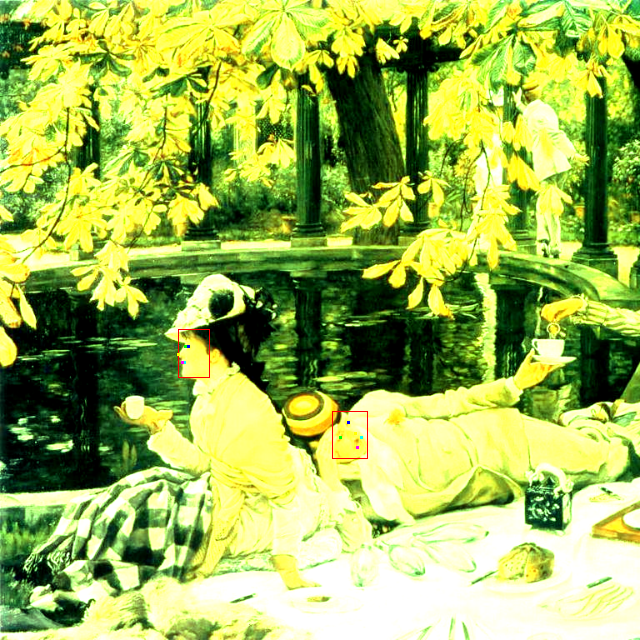

In [31]:
include("./BBTNet/utils/draw.jl")
draw_boxes_and_landmarks(img, bboxes)

## Drawing Image From Manual Data

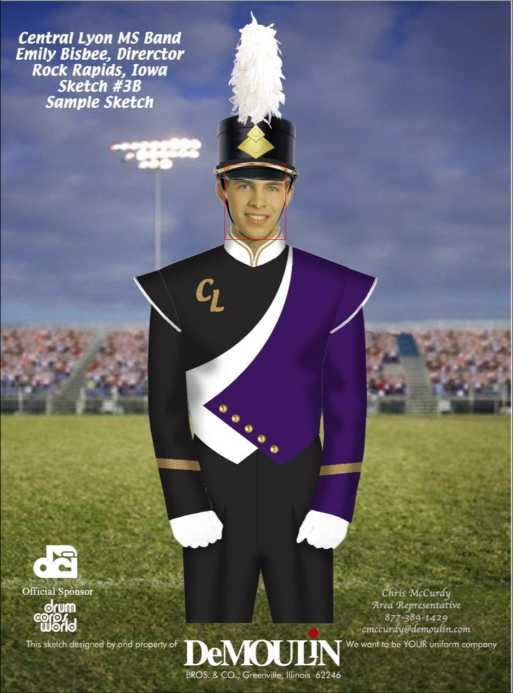

In [4]:
using Images

include("./BBTNet/utils/draw.jl")

data = reshape([449 330 571 479 488.906 373.643 542.089 376.442 515.031 412.83 485.174 425.893 538.357 431.491], (14, 1))
path = wf_path * "train/images/0--Parade/0_Parade_marchingband_1_849.jpg"

img = channelview(load(path))
draw_boxes_and_landmarks(img, data)

## Training the Model

In [20]:
include("BBTNet/models/retinaface.jl")

model = RetinaFace(dtype=atype)
print("Model is loaded!")

Model is loaded!

In [21]:
train_model(model, data, save_dir=save_dir)


--> TRAINING PROCESS:

Epoch: 1 & Batch: 4/12880 --> Total Loss: 41.517 | Cls Loss: 0.776 | Box Loss: 45.894 | Lm Loss: 0.0 | Decay: 5.153
Epoch: 1 & Batch: 8/12880 --> Total Loss: 60.409 | Cls Loss: 0.649 | Box Loss: 64.914 | Lm Loss: 0.0 | Decay: 5.153
Epoch: 1 & Batch: 12/12880 --> Total Loss: 61.086 | Cls Loss: 0.664 | Box Loss: 65.576 | Lm Loss: 0.0 | Decay: 5.155
Epoch: 1 & Batch: 16/12880 --> Total Loss: 24.266 | Cls Loss: 0.689 | Box Loss: 28.734 | Lm Loss: 0.0 | Decay: 5.157
Epoch: 1 & Batch: 20/12880 --> Total Loss: 18.341 | Cls Loss: 0.682 | Box Loss: 22.819 | Lm Loss: 0.0 | Decay: 5.159
Epoch: 1 & Batch: 24/12880 --> Total Loss: 18.269 | Cls Loss: 0.658 | Box Loss: 22.774 | Lm Loss: 0.0 | Decay: 5.163
Epoch: 1 & Batch: 28/12880 --> Total Loss: 35.239 | Cls Loss: 0.712 | Box Loss: 39.693 | Lm Loss: 0.0 | Decay: 5.166
Epoch: 1 & Batch: 32/12880 --> Total Loss: 122.891 | Cls Loss: 0.7 | Box Loss: 127.361 | Lm Loss: 0.0 | Decay: 5.17
Epoch: 1 & Batch: 36/12880 --> Total Loss: 

LoadError: InterruptException:

## Testing the Model

#### Testing a Batch

In [9]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

Random.seed!(42)

val_data = WIDER_Data(wf_path * "val/", wf_labels_path * "val/", train=false, batch_size=4, dtype=atype)
(imgs, boxes), state = iterate(val_data)

# model = RetinaFace(dtype=atype)
model = load_model(save_dir * "model_epoch1_iter12000.jld2")
c, b, l = model(imgs, nothing, mode, false, 0)

for b in 1:batch_size
    print("For Batch Image: ", b, " found ", size(c[b],1), " proposals!\n")
end

Int64[]Int64[]Int64[]Int64[]Returning prediction results above confidence level: 0.85.
For Batch Image: 1 found 1 proposals!
For Batch Image: 2 found 1 proposals!
For Batch Image: 3 found 1 proposals!
For Batch Image: 4 found 1 proposals!


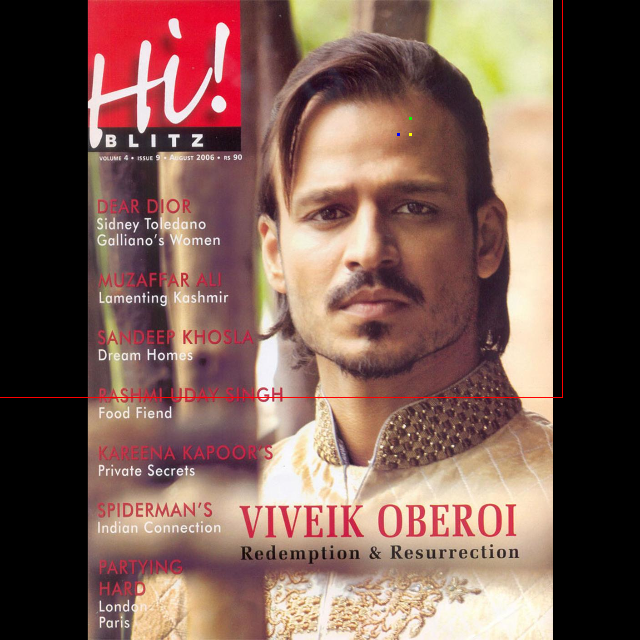

In [86]:
# image conversion to actual shape and cpu type for the first image in the prediction
img_no = 4
img_cpu = Array(permutedims(imgs[:,:,:,img_no], (3,2,1))) ./ 255 + avg_img
combined_pts = permutedims(Array(cat(b[img_no], l[img_no], dims=2)), (2, 1))

draw_boxes_and_landmarks(img_cpu, combined_pts)

#### Testing an Individual Image

In [15]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

sample_paths = [
    "18--Concerts/18_Concerts_Concerts_18_537.jpg", 
    "2--Demonstration/2_Demonstration_Demonstrators_2_688.jpg", 
    "0--Parade/0_Parade_Parade_0_652.jpg", 
    "55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_327.jpg"
]

dataset_path = wf_path * "train/images/" 
labels_path = wf_labels_path * "train/"
img_path = sample_paths[2]

val_data = WIDER_Data(dataset_path, labels_path, train=false, batch_size=1, dtype=atype)
img, box = read_img(val_data.reader, dataset_path * img_path, data.bboxes[img_path], img_size)
imgs = convert(data.dtype, permutedims(reshape(img, (size(img)..., 1)), (3,2,1,4))) .* 255
img += avg_img

model = load_model(save_dir * "model_epoch1_iter2000.jld2")
c, b, l = model(imgs, nothing, mode, false, 0)

combined_pts = permutedims(Array(cat(b[1], l[1], dims=2)), (2, 1))

draw_boxes_and_landmarks(img, combined_pts)

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 25500 and 25200")

## Saving & Loading the Model

In [6]:
save_model(model, save_dir * "dummy_path.jld2")

In [29]:
model = load_model(save_dir * "model_epoch1.jld2")
print("Model is loaded from a file!\n")

Model is loaded from a file!


## Issues on Loading ResNet50 Weights

In [19]:
include("./BBTNet/backbones/resnet.jl")
include("./BBTNet/utils/ImageReader.jl")
include("configs.jl")

img_path = "./data/cat_img.jpg"
img = convert(atype, read_img(Image_Reader(false), img_path, nothing, img_size))
img = permutedims(reshape(img, (1, 3, img_size, img_size)), (4, 3, 2, 1)) .* 255

rn = load_mat_weights(ResNet50(dtype=atype), "./weights/imagenet-resnet-50-dag.mat")
evaluate_model(rn, img)

tabby, tabby cat: 18.38%
wood rabbit, cottontail, cottontail rabbit: 14.25%
Egyptian cat: 8.93%
tiger cat: 5.48%
window screen: 4.92%
